## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = open('complaints.json') 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.
df.shape

(78313, 22)

In [4]:
# Check for the columns and defaulted datatype
df.dtypes

_index                                object
_type                                 object
_id                                   object
_score                               float64
_source.tags                          object
_source.zip_code                      object
_source.complaint_id                  object
_source.issue                         object
_source.date_received                 object
_source.state                         object
_source.consumer_disputed             object
_source.product                       object
_source.company_response              object
_source.company                       object
_source.submitted_via                 object
_source.date_sent_to_company          object
_source.company_public_response       object
_source.sub_product                   object
_source.timely                        object
_source.complaint_what_happened       object
_source.sub_issue                     object
_source.consumer_consent_provided     object
dtype: obj

In [5]:
#print the column names
cols = df.columns.to_list()
print("Columns names:\n",cols)

Columns names:
 ['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code', '_source.complaint_id', '_source.issue', '_source.date_received', '_source.state', '_source.consumer_disputed', '_source.product', '_source.company_response', '_source.company', '_source.submitted_via', '_source.date_sent_to_company', '_source.company_public_response', '_source.sub_product', '_source.timely', '_source.complaint_what_happened', '_source.sub_issue', '_source.consumer_consent_provided']


In [6]:
# Checking null value counts for each column.
df.isnull().sum()

_index                                   0
_type                                    0
_id                                      0
_score                                   0
_source.tags                         67413
_source.zip_code                      6757
_source.complaint_id                     0
_source.issue                            0
_source.date_received                    0
_source.state                         1991
_source.consumer_disputed                0
_source.product                          0
_source.company_response                 0
_source.company                          0
_source.submitted_via                    0
_source.date_sent_to_company             0
_source.company_public_response      78309
_source.sub_product                  10571
_source.timely                           0
_source.complaint_what_happened          0
_source.sub_issue                    46297
_source.consumer_consent_provided     1008
dtype: int64

### Insights:
 Few column name contains _ and _source , as it could be a problematic and without it the columns represents full meaning

In [7]:
# Assign new column names 
new_columns = [re.sub('source.|_','',col[1:]) for col in cols]
print("New column names:\n",new_columns, "\n")

#Check for the records if new column names take affect
df.columns = new_columns
df.head()

New column names:
 ['index', 'type', 'id', 'score', 'tags', 'zipcode', 'complaintid', 'issue', 'datereceived', 'state', 'consumerdisputed', 'product', 'companyresponse', 'company', 'submittedvia', 'datesenttocompany', 'companypublicresponse', 'subproduct', 'timely', 'complaintwhathappened', 'subissue', 'consumerconsentprovided'] 



,index,type,id,score,tags,zipcode,complaintid,issue,datereceived,state,...,companyresponse,company,submittedvia,datesenttocompany,companypublicresponse,subproduct,timely,complaintwhathappened,subissue,consumerconsentprovided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [8]:
# rename the column complaintwhathappend to complaint
df.rename(columns = {'complaintwhathappened':'complaint'}, inplace = True)

#print the top 5 rows
df.head()

,index,type,id,score,tags,zipcode,complaintid,issue,datereceived,state,...,companyresponse,company,submittedvia,datesenttocompany,companypublicresponse,subproduct,timely,complaint,subissue,consumerconsentprovided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


### Assign nan in place of blanks in the complaints column 

In [9]:
# check how many records are null 
df['complaint'].isnull().sum()

0

In [10]:
# Number of rows with blank complaints
total_blank_rows = len(df[(df['complaint'] == '') | (df['complaint'] == ' ')])
print('Number of rows with blank complaints ', total_blank_rows)

Number of rows with blank complaints  57241


In [11]:
#Remove all rows where complaints column is nan
df['complaint'] = df['complaint'].replace(r"^\s*$",np.NaN,regex=True)

In [12]:
#Check for the rows with null values
print('Columns with NAN values', df['complaint'].isnull().sum())

#Check the column with blank or empty spaces,it should be zero
total_blank_rows = len(df[(df['complaint'] == '') | (df['complaint'] == ' ')])
print('Columns with blank or empty spaces', total_blank_rows)

Columns with NAN values 57241
Columns with blank or empty spaces 0


In [13]:
# filter the rows with nan or null values
df = df[~df['complaint'].isnull()]

#We can see that 78313 = 21072 + 57241
print('Dataframe shape after removing the rows', df.shape)

Dataframe shape after removing the rows (21072, 22)


In [14]:
df.head()

,index,type,id,score,tags,zipcode,complaintid,issue,datereceived,state,...,companyresponse,company,submittedvia,datesenttocompany,companypublicresponse,subproduct,timely,complaint,subissue,consumerconsentprovided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [15]:
# Write your function here to clean the text and remove all the unnecessary elements.
def preProcessText(value):
    value = value.lower() # to lower case
    value = value.strip() # trim operation
    value = re.sub(r"[\[].*?[\]]","",value).strip() #remove within square bracket
    value = re.sub(r"[^\w\s]","",value).strip() # remove punctuation
    value = re.sub("\S*\d\S*","",value).strip() # remove wors containing numbers
    return value

df['complaint_cleaned'] = df['complaint'].apply(preProcessText)

df['complaint_cleaned'] 

1        good morning my name is xxxx xxxx and i apprec...
2        i upgraded my xxxx xxxx card in  and was told ...
10       chase card was reported on  however fraudulent...
11       on  while trying to book a xxxx  xxxx  ticket ...
14       my grand son give me check for  i deposit it i...
                               ...                        
78303    after being a chase card customer for well ove...
78309    on wednesday xxxxxxxx i called chas my xxxx xx...
78310    i am not familiar with xxxx pay and did not un...
78311    i have had flawless credit for  yrs ive had ch...
78312    roughly  years ago i closed out my accounts wi...
Name: complaint_cleaned, Length: 21072, dtype: object

In [16]:
df.head()

,index,type,id,score,tags,zipcode,complaintid,issue,datereceived,state,...,company,submittedvia,datesenttocompany,companypublicresponse,subproduct,timely,complaint,subissue,consumerconsentprovided,complaint_cleaned
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name is xxxx xxxx and i apprec...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided,i upgraded my xxxx xxxx card in and was told ...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided,chase card was reported on however fraudulent...
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,"On XX/XX/2018, while trying to book a XXXX XX...",Information belongs to someone else,Consent provided,on while trying to book a xxxx xxxx ticket ...
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for {$1600.00} i de...,Funds not handled or disbursed as instructed,Consent provided,my grand son give me check for i deposit it i...


### Write your function to Lemmatize the texts

In [17]:
# Import the necessary libraries for cleanup
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

!pip install swifter

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nyashasingh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nyashasingh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nyashasingh/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nyashasingh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import swifter # Importing "swifter" to speed up lemmatization using mutithread processing.

In [19]:
# Function to lemmatize the word
stopwords = stopwords.words('english')
wordnet_lem = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords]
    proc_token = []
    for word,pos in pos_tag(tokens):
        try:
            proc_token.append(wordnet_lem.lemmatize(word,pos = pos[0].lower()))
        except:
            proc_token.append(wordnet_lem.lemmatize(word))
    lemmatized_value = ' '.join(proc_token)
    return lemmatized_value

In [20]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df[["complaint"]]

# Apply lemmatization and store the output in a separate column
df_clean["complaint_lemmatized"] = df["complaint_cleaned"].swifter.apply(lemmatize_text)

/Users/nyashasingh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [21]:
df_clean

,complaint,complaint_lemmatized
1,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card tell agent upgrade ann...
10,Chase Card was reported on XX/XX/2019. However...,chase card report however fraudulent applicati...
11,"On XX/XX/2018, while trying to book a XXXX XX...",try book xxxx xxxx ticket come across offer ap...
14,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...
...,...,...
78303,After being a Chase Card customer for well ove...,chase card customer well decade offer multiple...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",wednesday xxxxxxxx call chas xxxx xxxx visa cr...
78310,I am not familiar with XXXX pay and did not un...,familiar xxxx pay understand great risk provid...
78311,I have had flawless credit for 30 yrs. I've ha...,flawless credit yrs ive chase credit card chas...


In [22]:
#Write your function to extract the POS tags 
nlp = spacy.load("en_core_web_sm")

from tqdm import tqdm
pos_tags = []
word_nouns = []

for complaint in tqdm(df_clean['complaint_lemmatized']):
    pos_tag = ''
    word_noun = ''
    proc_complaint = nlp(complaint)
    for tok in proc_complaint:
        pos_tag += tok.pos_ + ' '
        if tok.pos_ in str(('NOUN', 'PROPN')) :
            word_noun += (tok.lemma_.lower()) + ' '
    pos_tags.append(pos_tag.strip())
    word_nouns.append(word_noun.strip())

100%|██████████| 21072/21072 [06:43<00:00, 52.23it/s]


In [23]:
#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
#df_clean['complaint_POS_lemmatized'] = pd.Series(pos_tags, index=df_clean.index)
df_clean['complaint_POS_removed'] = pd.Series(word_nouns, index=df_clean.index)

#Reassigning index of cleaned dataframe
df_clean.reset_index(drop=True, inplace = True)

/Users/nyashasingh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [24]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint,complaint_lemmatized,complaint_POS_removed
0,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx chase bank cardmember s...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card tell agent upgrade ann...,xxxx card agent anniversary date agent informa...
2,Chase Card was reported on XX/XX/2019. However...,chase card report however fraudulent applicati...,chase card report application submit identity ...
3,"On XX/XX/2018, while trying to book a XXXX XX...",try book xxxx xxxx ticket come across offer ap...,book xxxx ticket offer ticket reward card info...
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check deposit chase account fund clear cha...
...,...,...,...
21067,After being a Chase Card customer for well ove...,chase card customer well decade offer multiple...,chase card customer decade solicitation credit...
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",wednesday xxxxxxxx call chas xxxx xxxx visa cr...,wednesday xxxxxxxx call xxxx xxxx visa credit ...
21069,I am not familiar with XXXX pay and did not un...,familiar xxxx pay understand great risk provid...,xxxx risk consumer chase bank app chase year t...
21070,I have had flawless credit for 30 yrs. I've ha...,flawless credit yrs ive chase credit card chas...,flawless credit yrs chase credit card chase fr...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [25]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean['complaint'].str.len().sort_values(ascending=False)

436      31611
11241    31385
14251    29948
2308     29239
1130     25757
         ...  
16450       21
8825        21
1619        20
5799        19
8697        19
Name: complaint, Length: 21072, dtype: int64

Text(0.5, 0, 'Complaint Character length ranges')

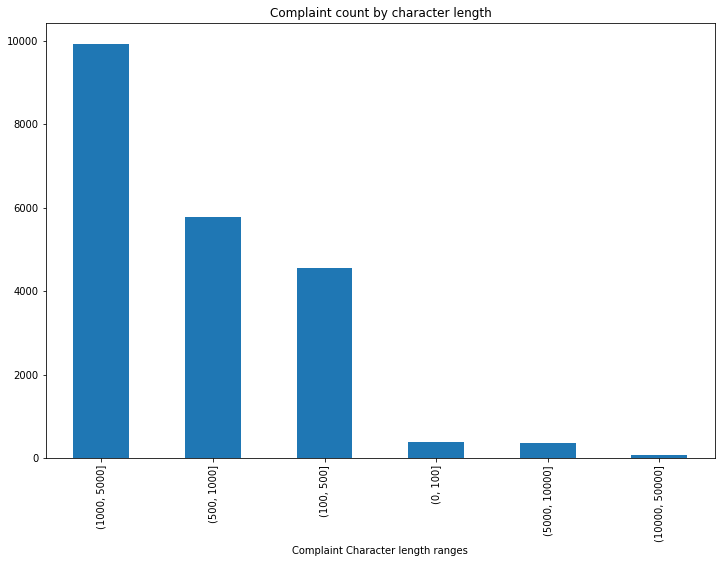

In [26]:
#Visualize the code in bins
bins = [0, 100, 500, 1000, 5000, 10000, 50000]
temp_df = df_clean['complaint'].str.len().to_frame()
temp_df.columns = ["length"]
temp_df['binned'] = pd.cut(temp_df['length'], bins)
temp_df.binned.value_counts()

plt.figure(figsize=(12,8))
temp_df.binned.value_counts().plot(kind="bar")
plt.title("Complaint count by character length")
plt.xlabel("Complaint Character length ranges")

#### Find the top 40 words by frequency among all the articles after processing the text.

Text(0.5, 1.0, 'Most frequent words in complaints after processing')

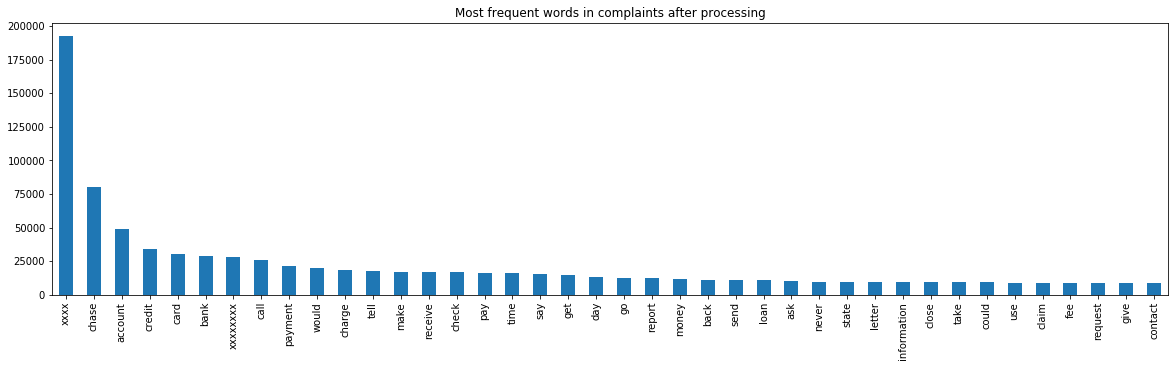

In [27]:
# Most frequent words in the processed (lemmatized) complaints

most_freq_lem=[]
for complaint in df_clean['complaint_lemmatized']:
    for word in complaint.split(' '):
        most_freq_lem.append(word)

plt.figure(figsize=(20, 5)) 
pd.DataFrame(most_freq_lem)[0].value_counts().head(40).plot(kind='bar')
plt.title("Most frequent words in complaints after processing")

#### Using a word cloud find the top 40 words by frequency among all the articles after processing the text

In [28]:
!pip install wordcloud

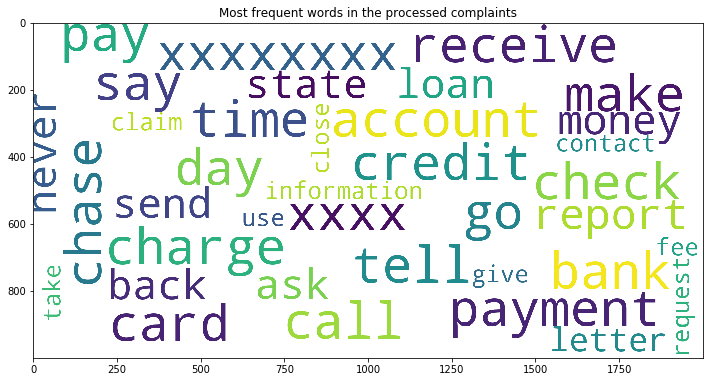

In [29]:
from wordcloud import WordCloud

plt.figure(figsize=(12, 12))
wordcloud = WordCloud(background_color = 'white', width = 2000, height = 1000, max_words = 50, contour_width = 3, colormap = 'viridis', max_font_size = 150, contour_color = 'steelblue', random_state = 0)

most_freq_words = pd.DataFrame(most_freq_lem)[0].value_counts().head(40).index
wordcloud.generate(' '.join([w for w in most_freq_words]))

plt.imshow(wordcloud)
plt.title("Most frequent words in the processed complaints")
plt.show()

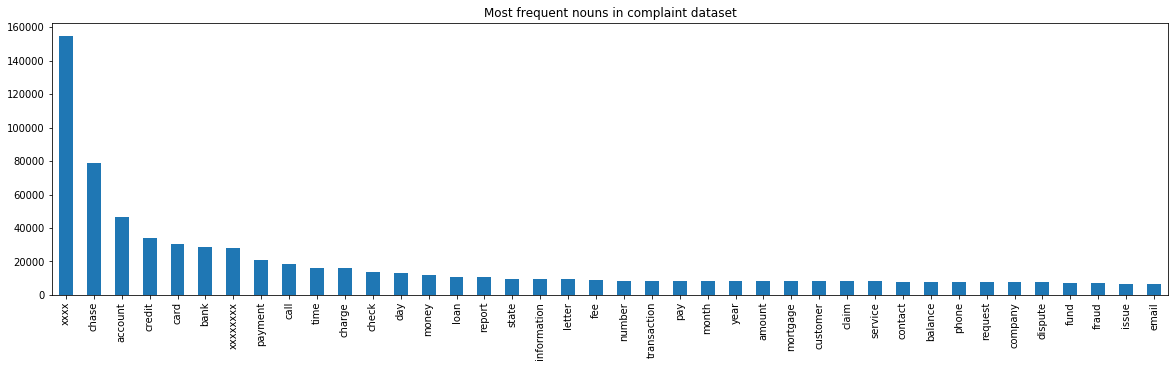

In [30]:
# Most frequent nouns in the processed complaints
most_freq_nouns=[] 
for complaint in df_clean['complaint_POS_removed']:
    for word in complaint.split(' '):
        most_freq_nouns.append(word)

plt.figure(figsize=(20, 5)) 
pd.DataFrame(most_freq_nouns)[0].value_counts().head(40).plot(kind='bar')
plt.title("Most frequent nouns in complaint dataset")
plt.show()

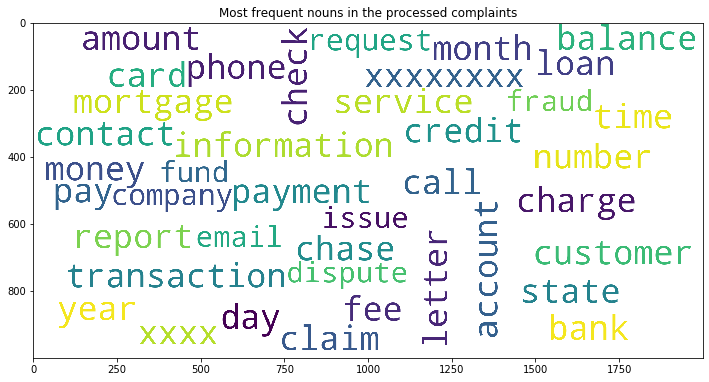

In [31]:
# Most frequest noun words

plt.figure(figsize=(12, 12))
wordcloud = WordCloud(background_color = 'white', width = 2000, height = 1000, max_words = 50, contour_width = 3, colormap = 'viridis', max_font_size = 100, contour_color = 'steelblue', random_state = 0)

most_freq_noun_words = pd.DataFrame(most_freq_nouns)[0].value_counts().head(40).index
wordcloud.generate(' '.join([w for w in most_freq_noun_words]))

plt.imshow(wordcloud)
plt.title("Most frequent nouns in the processed complaints")
plt.show()

In [32]:
#Removing -PRON- from the text corpus
df_clean['complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
df_clean

/Users/nyashasingh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,complaint,complaint_lemmatized,complaint_POS_removed,complaint_clean
0,Good morning my name is XXXX XXXX and I apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx chase bank cardmember s...,morning name xxxx xxxx chase bank cardmember s...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded xxxx xxxx card tell agent upgrade ann...,xxxx card agent anniversary date agent informa...,xxxx card agent anniversary date agent informa...
2,Chase Card was reported on XX/XX/2019. However...,chase card report however fraudulent applicati...,chase card report application submit identity ...,chase card report application submit identity ...
3,"On XX/XX/2018, while trying to book a XXXX XX...",try book xxxx xxxx ticket come across offer ap...,book xxxx ticket offer ticket reward card info...,book xxxx ticket offer ticket reward card info...
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check deposit chase account fund clear cha...,son check deposit chase account fund clear cha...
...,...,...,...,...
21067,After being a Chase Card customer for well ove...,chase card customer well decade offer multiple...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",wednesday xxxxxxxx call chas xxxx xxxx visa cr...,wednesday xxxxxxxx call xxxx xxxx visa credit ...,wednesday xxxxxxxx call xxxx xxxx visa credit ...
21069,I am not familiar with XXXX pay and did not un...,familiar xxxx pay understand great risk provid...,xxxx risk consumer chase bank app chase year t...,xxxx risk consumer chase bank app chase year t...
21070,I have had flawless credit for 30 yrs. I've ha...,flawless credit yrs ive chase credit card chas...,flawless credit yrs chase credit card chase fr...,flawless credit yrs chase credit card chase fr...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [33]:
# Import the libraries
from nltk.util import ngrams 
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [34]:
# Prepare dataframe with frequency and unique words
wordCountVector = CountVectorizer(ngram_range=(1,1), analyzer='word') 
word_vector = wordCountVector.fit_transform(df_clean['complaint_POS_removed']) 
frequencies = sum(word_vector).toarray()[0]
unigram_df = pd.DataFrame(frequencies, index = wordCountVector.get_feature_names(), columns=['frequency']) 

In [35]:
# Print the top 10 words in the unigram frequency
print("Top 30 words by frequency:")
unigram_df.sort_values(by="frequency", ascending = False).head(10)

Top 30 words by frequency:


,frequency
xxxx,154667
chase,78800
account,46689
credit,33964
card,30415
bank,28601
xxxxxxxx,27905
payment,21161
call,18453
time,16048


<Figure size 1440x360 with 0 Axes>

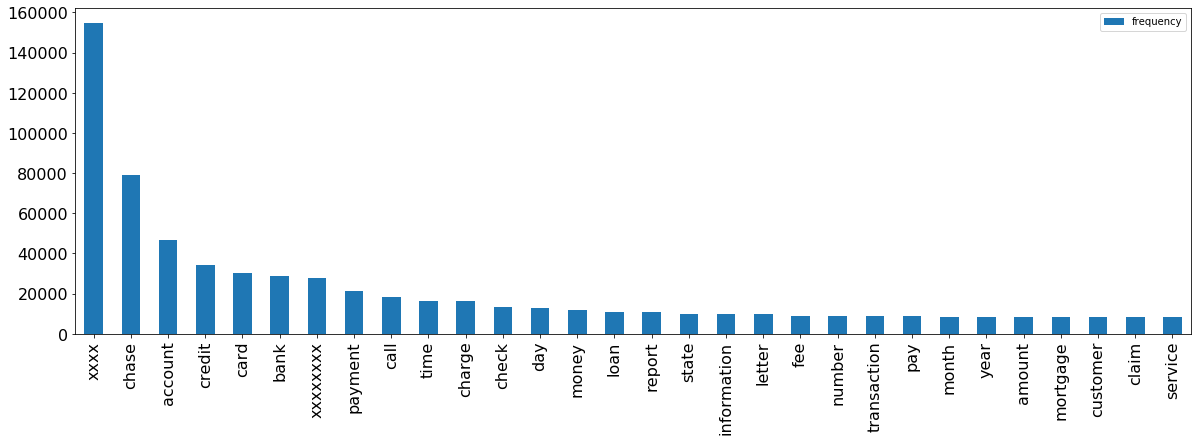

In [36]:
# Top 30 words by their frequency
plt.figure(figsize=(20, 5))
unigram_df.sort_values(by='frequency', ascending=False)[:30].plot(kind='bar', figsize=(20,6), fontsize=16)
plt.show()

In [37]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
wordCountVector = CountVectorizer(ngram_range=(2,2), analyzer='word') 
word_vector = wordCountVector.fit_transform(df_clean['complaint_POS_removed']) 
frequencies = sum(word_vector).toarray()[0]
bigram_df = pd.DataFrame(frequencies, index = wordCountVector.get_feature_names(), columns=['frequency'])

In [38]:
#Print the top 10 words in the bigram frequency
print("Top 10 bigrams by frequency:")
print(bigram_df.sort_values(by="frequency", ascending = False).head(10))

Top 10 bigrams by frequency:
               frequency
xxxx xxxx          67013
chase bank         12897
credit card        12840
xxxx chase          5473
call chase          4308
credit report       3993
xxxxxxxx xxxx       3638
check account       3551
chase xxxx          3442
chase credit        3384


<Figure size 1440x360 with 0 Axes>

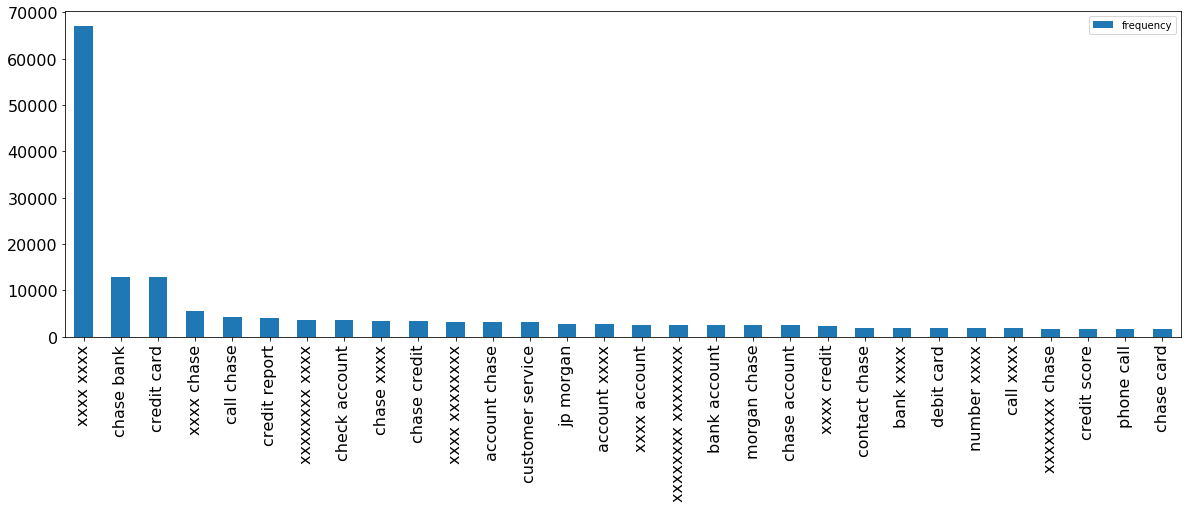

In [39]:
# Top 30 words by their bigram frequency
plt.figure(figsize=(20, 5))
bigram_df.sort_values(by='frequency', ascending=False)[:30].plot(kind='bar', figsize=(20,6), fontsize=16)
plt.show()

In [40]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
wordCountVector = CountVectorizer(ngram_range=(3,3), analyzer='word') 
word_vector = wordCountVector.fit_transform(df_clean['complaint_POS_removed']) 
frequencies = sum(word_vector).toarray()[0]
trigram_df = pd.DataFrame(frequencies, index = wordCountVector.get_feature_names(), columns=['frequency'])

In [41]:
#Print the top 10 words in the trigram frequency
print("Top 10 bigrams by frequency:")
print(trigram_df.sort_values(by="frequency", ascending = False).head(10))

Top 10 bigrams by frequency:
                    frequency
xxxx xxxx xxxx          32438
chase credit card        2351
xxxx xxxx chase          2348
jp morgan chase          2302
xxxxxxxx xxxx xxxx       1834
xxxx xxxx xxxxxxxx       1449
chase xxxx xxxx          1340
chase bank xxxx          1142
xxxx credit card         1101
xxxx xxxxxxxx xxxx       1087


<Figure size 1440x360 with 0 Axes>

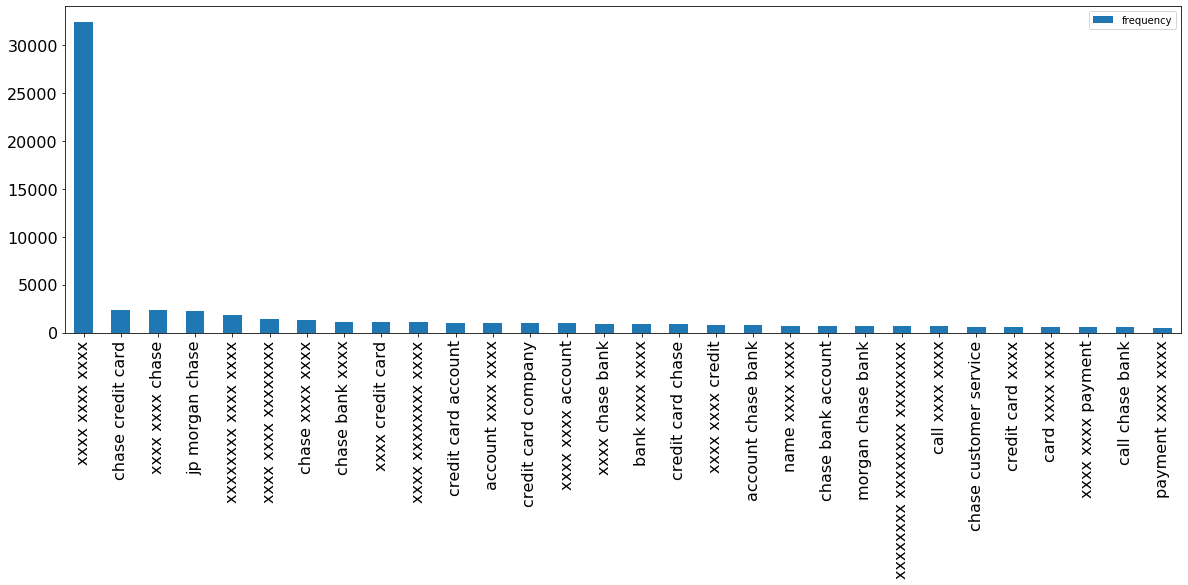

In [42]:
# Top 30 words by their trigram frequency
plt.figure(figsize=(20, 5))
trigram_df.sort_values(by='frequency', ascending=False)[:30].plot(kind='bar', figsize=(20,6), fontsize=16)
plt.show()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [43]:
df_clean['complaint_clean'] = df_clean['complaint_clean'].str.replace('xxxx','')
df_clean['complaint_lemmatized'] = df_clean['complaint_lemmatized'].str.replace('xxxx','')
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].str.replace('xxxx','')

/Users/nyashasingh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/nyashasingh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/nyashasingh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [44]:
#All masked texts has been removed
df_clean

,complaint,complaint_lemmatized,complaint_POS_removed,complaint_clean
0,Good morning my name is XXXX XXXX and I apprec...,good morning name appreciate could help put ...,morning name chase bank cardmember service c...,morning name chase bank cardmember service c...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded card tell agent upgrade anniversary...,card agent anniversary date agent information...,card agent anniversary date agent information...
2,Chase Card was reported on XX/XX/2019. However...,chase card report however fraudulent applicati...,chase card report application submit identity ...,chase card report application submit identity ...
3,"On XX/XX/2018, while trying to book a XXXX XX...",try book ticket come across offer apply towa...,book ticket offer ticket reward card informat...,book ticket offer ticket reward card informat...
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check deposit chase account fund clear cha...,son check deposit chase account fund clear cha...
...,...,...,...,...
21067,After being a Chase Card customer for well ove...,chase card customer well decade offer multiple...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",wednesday call chas visa credit card provid...,wednesday call visa credit card provider as...,wednesday call visa credit card provider as...
21069,I am not familiar with XXXX pay and did not un...,familiar pay understand great risk provide co...,risk consumer chase bank app chase year trust...,risk consumer chase bank app chase year trust...
21070,I have had flawless credit for 30 yrs. I've ha...,flawless credit yrs ive chase credit card chas...,flawless credit yrs chase credit card chase fr...,flawless credit yrs chase credit card chase fr...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [45]:
#Write your code here to initialise the TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    min_df=2,
    max_df=0.95,
    stop_words='english',
    max_features=5000,
    ngram_range=(1, 3)
)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [46]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tfidf = tfidf_vectorizer.fit_transform(df_clean['complaint_POS_removed'])
features = tfidf_vectorizer.get_feature_names()

# Creating a dataframe to display the document-term matrix created above
tfidf_df = pd.DataFrame(tfidf.toarray(), columns = features)
tfidf_df.head()

,ability,abuse,acceptance,access,access account,access bank,access chase,access check,access credit,access fund,...,year mortgage,year pay,year payment,year time,year work,year year,yesterday,york,yr,zip
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
# Check the shape of dataframe
tfidf_df.shape

(21072, 5000)

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [48]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [49]:
def model_topics(num_topics=5):
    #Load your nmf_model with the n_components i.e 5
   
    #keep the random_state =40
    nmf_model = NMF(n_components=num_topics, random_state=40) #write your code here
    
    W = nmf_model.fit_transform(tfidf)  # Document-Topic matrix
    H = nmf_model.components_           # Topic-Term matrix)
    
    #Print the Top15 words for each of the topics
    words = np.array(tfidf_vectorizer.get_feature_names())
    topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                               columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
    for i in range(num_topics):
        ix = H[i].argsort()[::-1][:15]
        topic_words.iloc[i] = words[ix]

    topic_words
    
    return W, H

In [50]:
#Load your nmf_model with the n_components i.e 5
model_topics(15)

(array([[0.00970046, 0.        , 0.        , ..., 0.12039878, 0.        ,
         0.        ],
        [0.00959738, 0.0100628 , 0.        , ..., 0.00196111, 0.00012624,
         0.        ],
        [0.00185458, 0.02342887, 0.        , ..., 0.00031105, 0.00124644,
         0.        ],
        ...,
        [0.00611483, 0.        , 0.00025511, ..., 0.00267054, 0.        ,
         0.00457315],
        [0.00027157, 0.06996355, 0.00167972, ..., 0.        , 0.00382206,
         0.01325801],
        [0.01957809, 0.00518215, 0.00298266, ..., 0.00683245, 0.00189885,
         0.00239153]]),
 array([[0.02718198, 0.0157186 , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.01278342, 0.0088886 , 0.00107426, ..., 0.00138586, 0.00212914,
         0.00300299],
        [0.00650319, 0.03156467, 0.00068285, ..., 0.        , 0.00143762,
         0.        ],
        ...,
        [0.01788624, 0.02077009, 0.00566763, ..., 0.00388655, 0.        ,
         0.00150582],
        [0.0

### Try with 5 topics

In [51]:
num_topics = 5
W,H = model_topics(5)

In [52]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_mapping = {
    'Topic 1' : 0,
    'Topic 2' : 1,
    'Topic 3' : 2,
    'Topic 4' : 3,
    'Topic 5' : 4
}

In [53]:
W = pd.DataFrame(W, columns=[f'Topic {i+1}' for i in range(num_topics)])
W['max_topic'] = W.apply(lambda x: topic_mapping.get(x.idxmax()) if x.idxmax() in topic_mapping.keys() else '4', axis=1)
W[pd.notnull(W['max_topic'])].head(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,max_topic
0,0.022794,0.005932,0.020167,0.011959,0.004513,0
1,0.006353,0.015064,0.004879,0.002476,0.001219,1
2,0.000000,0.022426,0.002416,0.039582,0.000000,3
3,0.018633,0.020651,0.017159,0.064609,0.000000,3
4,0.062394,0.000000,0.001739,0.000000,0.000000,0
5,0.000000,0.000000,0.000000,0.103981,0.000000,3
6,0.050834,0.004446,0.010334,0.000000,0.011729,0
7,0.001576,0.006360,0.042123,0.000027,0.052579,4
8,0.035969,0.023491,0.021105,0.005580,0.001448,0
9,0.000000,0.045408,0.000000,0.065895,0.000000,3


In [54]:
# Checking the frequency
W['max_topic'].value_counts()

1    6276
0    5959
2    3918
3    2520
4    2399
Name: max_topic, dtype: int64

In [55]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = W['max_topic'].apply(lambda x:int(x))#write your code to assign topics to each rows.

/Users/nyashasingh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [56]:
df_clean.head()

,complaint,complaint_lemmatized,complaint_POS_removed,complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning name appreciate could help put ...,morning name chase bank cardmember service c...,morning name chase bank cardmember service c...,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded card tell agent upgrade anniversary...,card agent anniversary date agent information...,card agent anniversary date agent information...,1
2,Chase Card was reported on XX/XX/2019. However...,chase card report however fraudulent applicati...,chase card report application submit identity ...,chase card report application submit identity ...,3
3,"On XX/XX/2018, while trying to book a XXXX XX...",try book ticket come across offer apply towa...,book ticket offer ticket reward card informat...,book ticket offer ticket reward card informat...,3
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check deposit chase account fund clear cha...,son check deposit chase account fund clear cha...,0


In [57]:
df_clean.Topic.value_counts()

1    6276
0    5959
2    3918
3    2520
4    2399
Name: Topic, dtype: int64

In [58]:
#Print the first 5 Complaint for each of the Topics
df_clean_topic = df_clean.groupby('Topic').head(5)
df_clean_topic.sort_values('Topic')

,complaint,complaint_lemmatized,complaint_POS_removed,complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning name appreciate could help put ...,morning name chase bank cardmember service c...,morning name chase bank cardmember service c...,0
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check deposit chase account fund clear cha...,son check deposit chase account fund clear cha...,0
10,mishandling of this account by Chase auto and ...,mishandle account chase auto,mishandle account chase auto,mishandle account chase auto,0
6,With out notice J.P. Morgan Chase restricted m...,notice jp morgan chase restrict account debit ...,jp morgan chase restrict account debit card tu...,jp morgan chase restrict account debit card tu...,0
8,"On XXXX XX/XX/2019, I made a {$300.00} payment...",make payment online retailer use chase quick ...,payment retailer use chase pay chase website...,payment retailer use chase pay chase website...,0
21,I AM A SENIOR CITIZEN THAT HAS BEEN SCAMMED BY...,senior citizen scammed several company pay t...,citizen company time share company credit car...,citizen company time share company credit car...,1
19,I made a purchase with XXXX XXXX XXXX on XX/XX...,make purchase amount charge twice transacti...,purchase amount charge transaction place di...,purchase amount charge transaction place di...,1
16,"XXXX XXXX a sofa, love seat, table and chairs ...",sofa love seat table chair never deliver deb...,sofa seat table chair debit card charge bank...,sofa seat table chair debit card charge bank...,1
14,My chase amazon card was declined for a cateri...,chase amazon card decline cater order place br...,chase amazon card decline cater order place br...,chase amazon card decline cater order place br...,1
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded card tell agent upgrade anniversary...,card agent anniversary date agent information...,card agent anniversary date agent information...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [59]:
#Create the dictionary of Topic names and Topics

Topic_names = { 
                0 : "Bank account services",
                1 : "Credit Card/Prepaid Card",
                2 : "Mortgages/loans",
                3 : "Theft/Dispute reporting",
                4 : "Others"
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

/Users/nyashasingh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [60]:
df_clean

,complaint,complaint_lemmatized,complaint_POS_removed,complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning name appreciate could help put ...,morning name chase bank cardmember service c...,morning name chase bank cardmember service c...,Bank account services
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded card tell agent upgrade anniversary...,card agent anniversary date agent information...,card agent anniversary date agent information...,Credit Card/Prepaid Card
2,Chase Card was reported on XX/XX/2019. However...,chase card report however fraudulent applicati...,chase card report application submit identity ...,chase card report application submit identity ...,Theft/Dispute reporting
3,"On XX/XX/2018, while trying to book a XXXX XX...",try book ticket come across offer apply towa...,book ticket offer ticket reward card informat...,book ticket offer ticket reward card informat...,Theft/Dispute reporting
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check deposit chase account fund clear cha...,son check deposit chase account fund clear cha...,Bank account services
...,...,...,...,...,...
21067,After being a Chase Card customer for well ove...,chase card customer well decade offer multiple...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,Credit Card/Prepaid Card
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",wednesday call chas visa credit card provid...,wednesday call visa credit card provider as...,wednesday call visa credit card provider as...,Credit Card/Prepaid Card
21069,I am not familiar with XXXX pay and did not un...,familiar pay understand great risk provide co...,risk consumer chase bank app chase year trust...,risk consumer chase bank app chase year trust...,Bank account services
21070,I have had flawless credit for 30 yrs. I've ha...,flawless credit yrs ive chase credit card chas...,flawless credit yrs chase credit card chase fr...,flawless credit yrs chase credit card chase fr...,Others


In [61]:
#df_clean['Topic']
df_clean.shape

(21072, 5)

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [62]:
#Create the dictionary again of Topic names and Topics

Topic_names = { 
    "Bank account services" : 0,
    "Credit Card/Prepaid Card" : 1,
    "Mortgages/loans" : 2,
    "Theft/Dispute reporting" : 3,
    "Others" : 4
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

/Users/nyashasingh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [63]:
df_clean

,complaint,complaint_lemmatized,complaint_POS_removed,complaint_clean,Topic
0,Good morning my name is XXXX XXXX and I apprec...,good morning name appreciate could help put ...,morning name chase bank cardmember service c...,morning name chase bank cardmember service c...,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,upgraded card tell agent upgrade anniversary...,card agent anniversary date agent information...,card agent anniversary date agent information...,1
2,Chase Card was reported on XX/XX/2019. However...,chase card report however fraudulent applicati...,chase card report application submit identity ...,chase card report application submit identity ...,3
3,"On XX/XX/2018, while trying to book a XXXX XX...",try book ticket come across offer apply towa...,book ticket offer ticket reward card informat...,book ticket offer ticket reward card informat...,3
4,my grand son give me check for {$1600.00} i de...,grand son give check deposit chase account fun...,son check deposit chase account fund clear cha...,son check deposit chase account fund clear cha...,0
...,...,...,...,...,...
21067,After being a Chase Card customer for well ove...,chase card customer well decade offer multiple...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,1
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",wednesday call chas visa credit card provid...,wednesday call visa credit card provider as...,wednesday call visa credit card provider as...,1
21069,I am not familiar with XXXX pay and did not un...,familiar pay understand great risk provide co...,risk consumer chase bank app chase year trust...,risk consumer chase bank app chase year trust...,0
21070,I have had flawless credit for 30 yrs. I've ha...,flawless credit yrs ive chase credit card chas...,flawless credit yrs chase credit card chase fr...,flawless credit yrs chase credit card chase fr...,4


In [64]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[["complaint", "Topic"]]

In [65]:
training_data

,complaint,Topic
0,Good morning my name is XXXX XXXX and I apprec...,0
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,1
2,Chase Card was reported on XX/XX/2019. However...,3
3,"On XX/XX/2018, while trying to book a XXXX XX...",3
4,my grand son give me check for {$1600.00} i de...,0
...,...,...
21067,After being a Chase Card customer for well ove...,1
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",1
21069,I am not familiar with XXXX pay and did not un...,0
21070,I have had flawless credit for 30 yrs. I've ha...,4


In [66]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21072 entries, 0 to 21071
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   complaint  21072 non-null  object
 1   Topic      21072 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 329.4+ KB


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [67]:
#Write your code to get the Vector count
vectorizer = CountVectorizer(ngram_range=(1,3), stop_words='english', max_df=0.95, min_df=0.02)
vector = vectorizer.fit_transform(training_data['complaint'])

print(vector.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [6 0 0 ... 1 1 0]
 [2 0 0 ... 3 1 0]]


In [68]:
#Write your code here to transform the word vector to tf-idf
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer =TfidfTransformer(use_idf=True).fit(vector)
word_vect = tfidf_transformer.transform(vector)
word_vect.shape

(21072, 883)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [69]:
# Write your code here to build any 3 models and evaluate them using the required metrics



